# Managing decisions with Bayesian AB tests

In [2]:
import arviz as az
import pymc as pm
import xarray as xa
import numpy as np
import pytensor.tensor as pt
import seaborn as sns
import scipy.stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import *
az.style.use("arviz-white")

## Bayesian Power Move, ABCD Testing

As mentioned above, multiple hypothesis testing is elegant with the Bayesian approach. Interpreting the results is much easier since you have uncertainty in mind for both:

1. If an experiment is a better option
2. Relative comparison between options

### Generating Data

For the dirty hands experiment we first generate an example data. Uneven sample sizes we chosen on purpose to demonstrate the flexibility of the Bayesian approach.

> A more prepared experiment should calculate sample sizes beforehand. That will help to set up proper expectations about the outcomes ETA

In [3]:
def get_alpha_beta(mu, sigma):
    kappa = mu * (1 - mu) / sigma**2 - 1
    alpha = mu * kappa
    beta = (1 - mu) * kappa
    alpha[alpha <= 0] = np.nan
    beta[beta <= 0] = np.nan
    return np.nan_to_num(alpha, nan=np.nan, posinf=np.nan), np.nan_to_num(beta, nan=np.nan, posinf=np.nan)

In [4]:
def max_sigma(mu):
    return (mu * (1 - mu))**.5

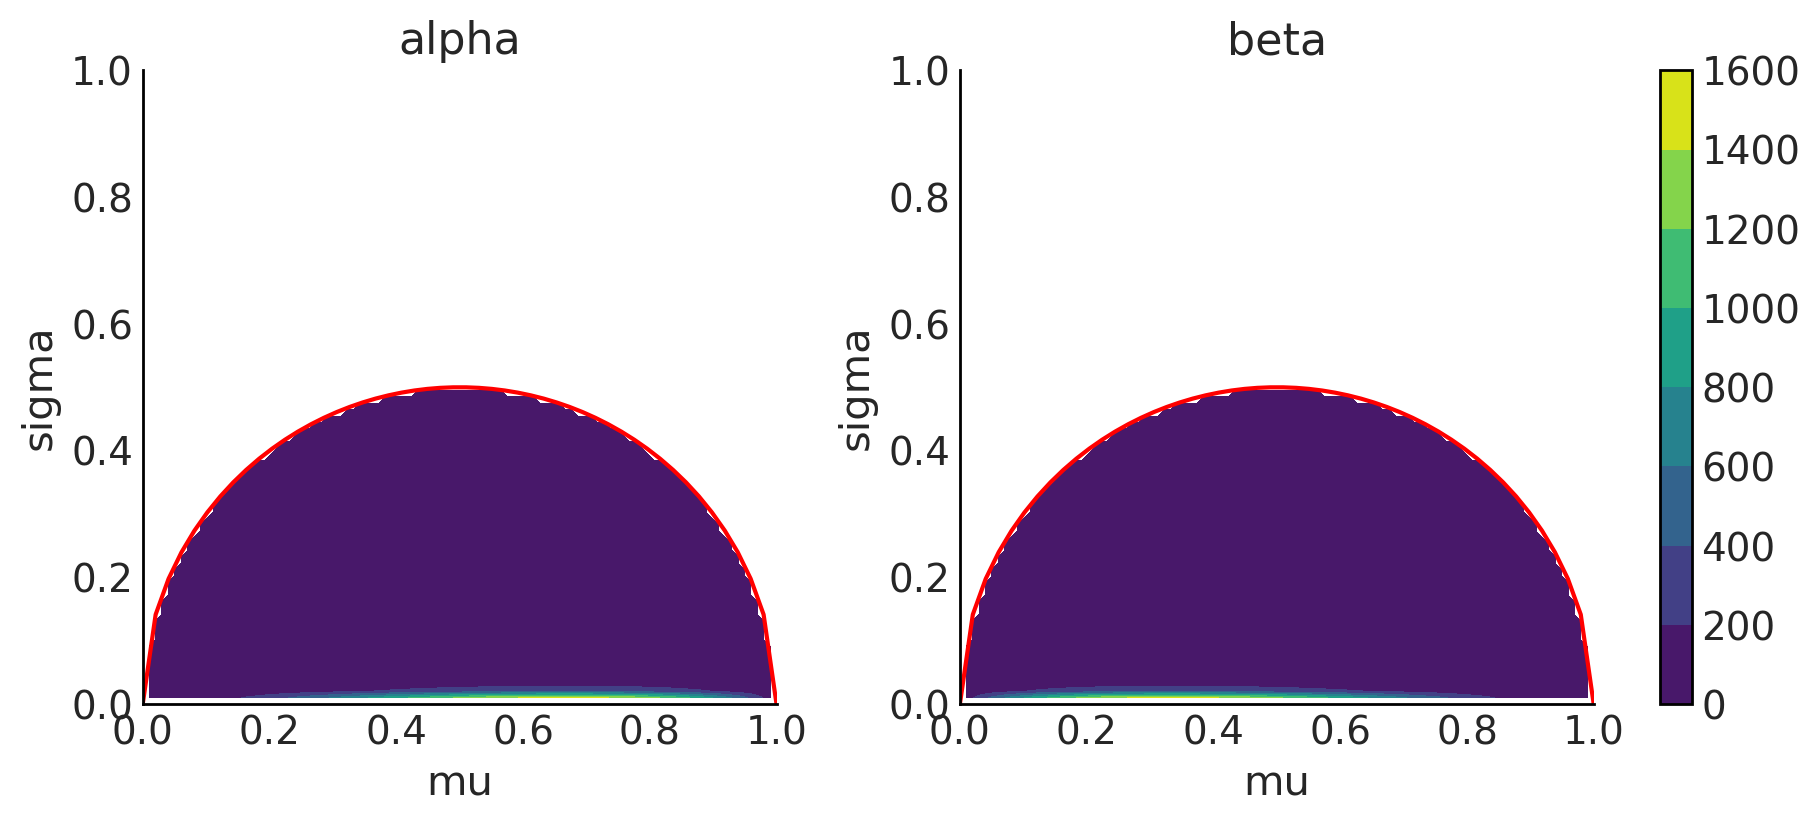

In [5]:
mu, sigma = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
with np.errstate(all="ignore"):
    alpha, beta = get_alpha_beta(mu[None], sigma[:, None])
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].contourf(mu, sigma, alpha)
ax[0].set_title("alpha")
ax[1].set_title("beta")
ax[0].set_xlabel("mu")
ax[0].set_ylabel("sigma")
ax[1].set_xlabel("mu")
ax[1].set_ylabel("sigma")
plt.colorbar(ax[1].contourf(mu, sigma, beta));
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
ax[0].plot(np.linspace(0, 1), max_sigma(np.linspace(0, 1)), color="red")
ax[1].plot(np.linspace(0, 1), max_sigma(np.linspace(0, 1)), color="red")

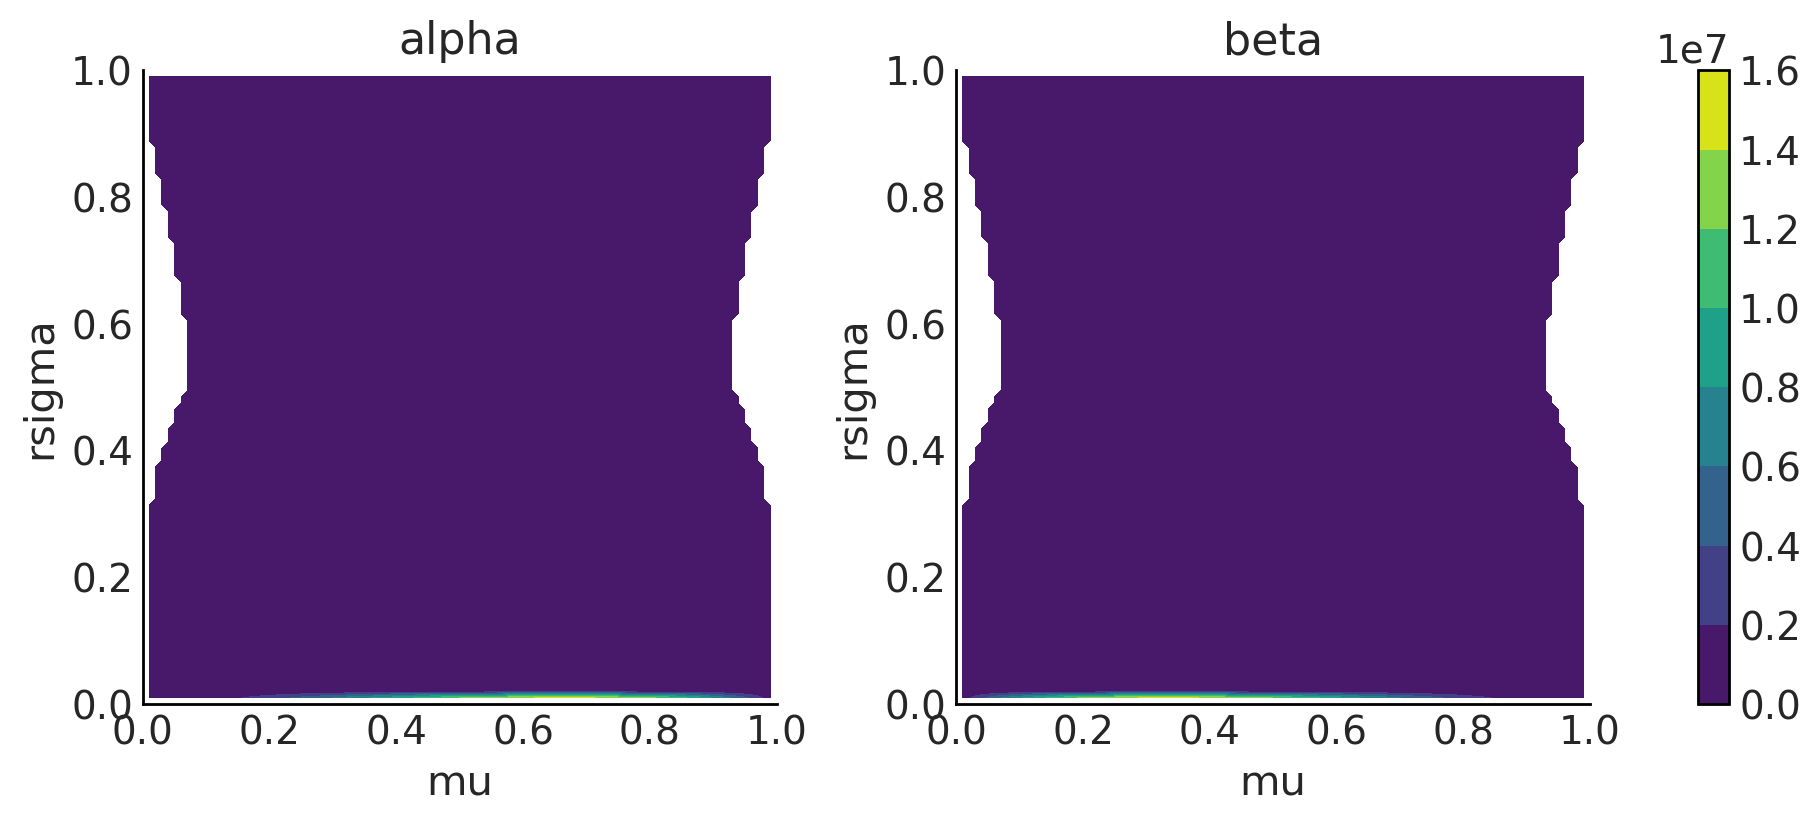

In [13]:
mu, rsigma = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
with np.errstate(all="ignore"):
    alpha, beta = get_alpha_beta(mu[None], np.minimum(mu[:, None], 1-mu[:, None])*rsigma[:, None])
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].contourf(mu, rsigma, alpha)
ax[0].set_title("alpha")
ax[1].set_title("beta")
ax[0].set_xlabel("mu")
ax[0].set_ylabel("rsigma")
ax[1].set_xlabel("mu")
ax[1].set_ylabel("rsigma")
plt.colorbar(ax[1].contourf(mu, rsigma, beta));
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")

In [14]:
def generate_data(*, probs: Iterable[float], sizes: Iterable[int], seed=42):
    labels = list("abcdefghijklmnopqrstuvwxyz")[:len(probs)]
    obs = np.random.RandomState(seed).binomial(
        sizes, 
        probs
    )
    return pd.DataFrame(dict(
        label=labels,
        success=obs,
        trials=sizes,
        oracle_prob=probs
    ))

In [15]:
baseline_prob = 0.2
oracle_uplifts_relative = np.array([0.01, 0.03, 0.025, -0.05, 0.2, -0.1, 0.001])
oracle_uplifts = baseline_prob * oracle_uplifts_relative
data = generate_data(
    probs=baseline_prob + oracle_uplifts,
    sizes=[121323, 10000, 213123, 12359683, 8588, 34243, 1200300]
)
oracle_uplifts

array([ 0.002 ,  0.006 ,  0.005 , -0.01  ,  0.04  , -0.02  ,  0.0002])

### Model setup

The model we used in the previous blog post is sufficient to look into the use-case. More complicated likelihoods will be covered in a separate blog post. 

In [16]:
def uplift_prior_p(baseline_p, expected_uplift, *, dims=None):
    experiment_p = pm.Beta(
        "experiment_p",
        mu=baseline_p, 
        sigma=expected_uplift,
        dims=dims
    )
    uplift_p = pm.Deterministic(
        "uplift_p",
        experiment_p - baseline_p,
        dims=dims
    )
    uplift_p_relative = pm.Deterministic(
        "uplift_p_relative",
        experiment_p / baseline_p - 1,
        dims=dims
    )
    return experiment_p

def binomial_abc_model(data, *, baseline_p: float, expected_uplift: float, name=""):
    with pm.Model(coords=dict(exp=data["label"]), name=name) as model:
        # p = pm.Beta("baseline_p", mu=baseline_p, sigma=0.01*baseline_p)
        p = baseline_p
        experiment_p = uplift_prior_p(p, expected_uplift, dims="exp")
        lik = pm.Binomial(
            "experiment_likelihood", 
            n=pm.Data("trials", data["trials"], mutable=False), 
            p=experiment_p, 
            observed=pm.Data("success", data["success"], mutable=False)
        )
    return model

For the prior expected uplift we choose **RELATIVE** 2%. So some experiments fall into different buckets. 

In [17]:
expected_uplift_relative = 0.02
expected_uplift = expected_uplift_relative*baseline_prob

In [18]:
expected_uplift

0.004

In [19]:
data

,label,success,trials,oracle_prob
0,a,24369,121323,0.2020
1,b,2093,10000,0.2060
2,c,43711,213123,0.2050
3,d,2345953,12359683,0.1900
4,e,2070,8588,0.2400
5,f,6019,34243,0.1800
6,g,240073,1200300,0.2002


In [21]:
with binomial_abc_model(data, baseline_p=baseline_prob, expected_uplift=expected_uplift) as model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [experiment_p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


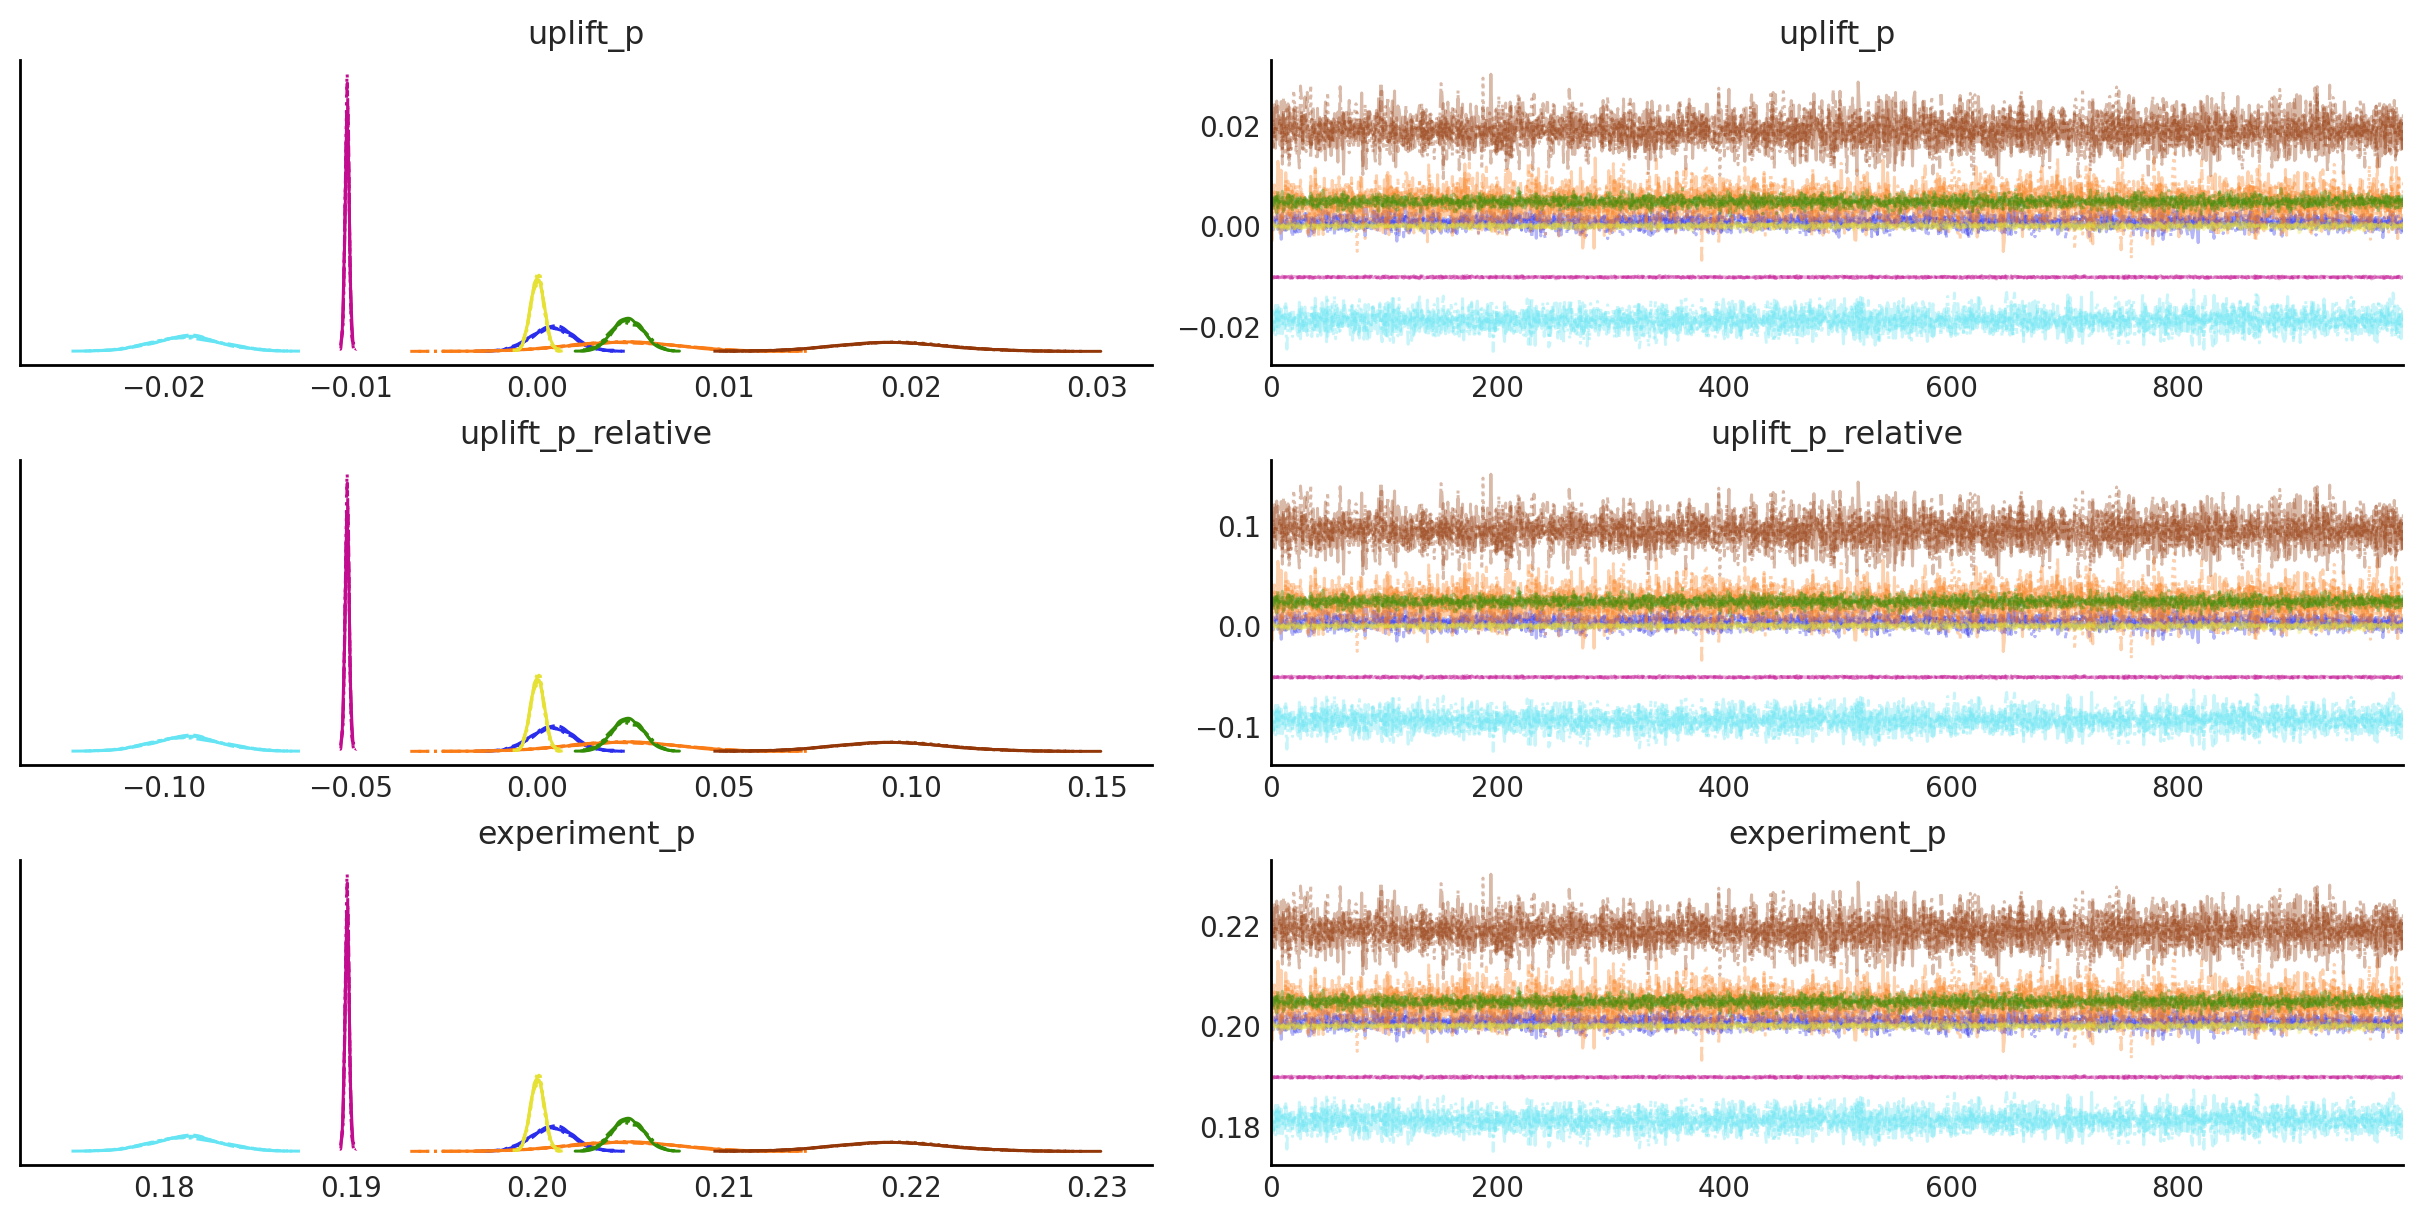

In [22]:
az.plot_trace(trace, var_names=["uplift_p", "uplift_p_relative", "experiment_p"]);

After a couple of seconds the model is fit. We can analyze the results and make conclusions.

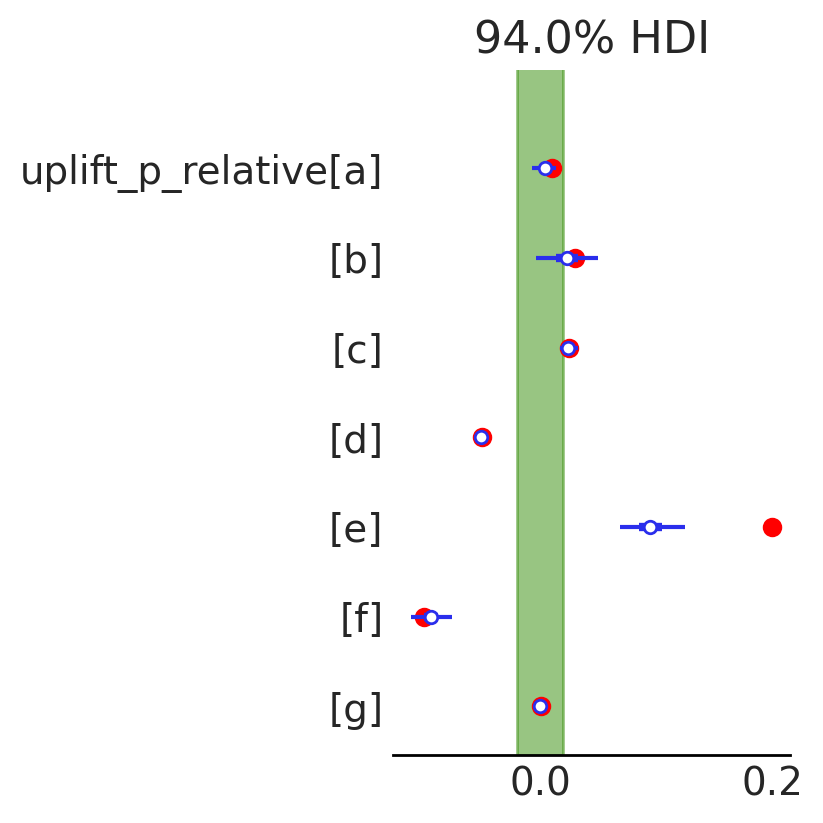

In [86]:
az.plot_forest(trace, var_names=["uplift_p_relative"], rope=[-0.02, 0.02], figsize=(4, 4), combined=True);
plt.scatter(oracle_uplifts_relative, plt.yticks()[0][::-1], color="red", label="oracle")

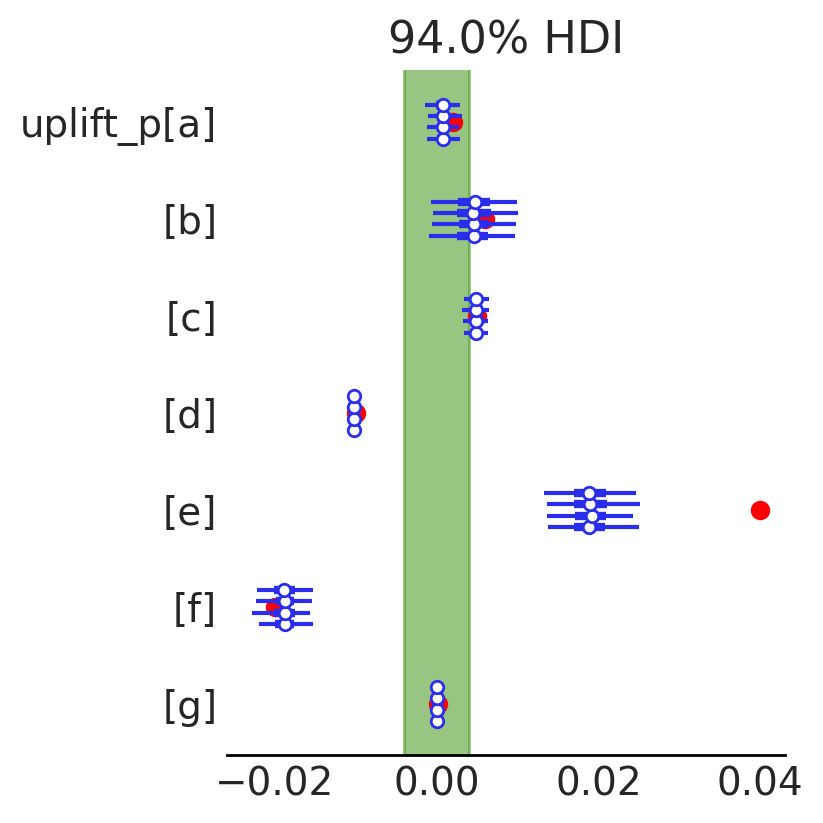

In [26]:
az.plot_forest(trace, var_names=["uplift_p"], rope=[-0.004, 0.004], figsize=(4, 4));
plt.scatter(oracle_uplifts, plt.yticks()[0][::-1], color="red", label="oracle")

In [29]:
np.arange(10) * np.arange(10).reshape(10, 1)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18],
       [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
       [ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36],
       [ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45],
       [ 0,  6, 12, 18, 24, 30, 36, 42, 48, 54],
       [ 0,  7, 14, 21, 28, 35, 42, 49, 56, 63],
       [ 0,  8, 16, 24, 32, 40, 48, 56, 64, 72],
       [ 0,  9, 18, 27, 36, 45, 54, 63, 72, 81]])

In [34]:
array_1 = trace.posterior.uplift_p_relative.mean(["draw", "exp"])
array_2 = trace.posterior.uplift_p_relative.mean(["chain", "exp"])

In [35]:
array_1

<xarray.DataArray 'uplift_p_relative' (chain: 4)>
array([0.00011356, 0.00028973, 0.00026901, 0.00020804])
Coordinates:
  * chain    (chain) int64 0 1 2 3

In [36]:
array_2

<xarray.DataArray 'uplift_p_relative' (draw: 1000)>
array([ 1.58406051e-03, -2.87249550e-03, -3.03536259e-04,  3.16047246e-03,
        3.85762463e-04,  1.41604667e-03,  2.75418201e-03,  1.19732046e-03,
       -1.30959345e-03,  2.49027286e-03, -4.29520262e-03,  1.24838255e-03,
        6.91016933e-04,  1.67853125e-03, -1.39829342e-03,  1.62422999e-03,
       -1.91777172e-03, -1.26441748e-03,  1.75867276e-04, -1.21308639e-03,
        3.91914450e-03,  1.22322809e-03, -6.41988415e-04, -6.18199282e-04,
       -1.43470508e-03, -8.58168930e-04,  1.98412892e-03,  4.32744561e-03,
       -3.50727200e-03,  1.60926033e-03,  3.05273240e-03, -9.20944503e-04,
       -1.09003574e-03, -3.27383703e-03, -2.57080059e-03,  1.39706314e-03,
        6.43228609e-05, -1.03220862e-03, -1.65850680e-03,  2.87740603e-03,
       -1.30913134e-03, -1.81730902e-03, -2.22378767e-03,  1.35463630e-03,
        9.30010759e-04,  9.54354487e-04,  1.63556032e-04, -1.04957415e-03,
        1.21117844e-04,  2.58053739e-03,  7.71837511e-04, -2.69111933e-03,
       -4.77299591e-04, -4.46275183e-04,  5.55202768e-05, -1.08485735e-04,
        4.25499297e-04,  3.17986487e-03,  2.03715450e-03, -1.35069507e-03,
       -4.68867032e-05,  1.91022535e-03,  1.07166741e-03, -1.35850810e-03,
        1.36265593e-03,  2.61043555e-03,  1.15620222e-03,  5.30899273e-04,
       -1.32531032e-03,  1.08223536e-03,  5.58737547e-05,  2.50174342e-03,
        2.60408680e-04,  2.96869892e-04,  6.04557017e-04, -5.81894441e-04,
       -2.40938099e-03, -6.37679038e-04,  1.31326449e-03,  1.05226758e-03,
...
        1.76164490e-03,  3.24577734e-04, -5.47206800e-04,  4.34339335e-03,
       -1.41678959e-03,  2.33936344e-03, -1.40656653e-03, -3.33424273e-03,
        8.37412350e-04,  3.07506984e-03, -1.79814580e-03,  2.49612612e-03,
       -1.21588189e-03, -1.38700210e-03,  1.50687640e-03, -3.83868788e-04,
        2.03378850e-03, -1.04253765e-03,  3.60318554e-03,  1.68431311e-04,
       -1.20883176e-04, -1.87789292e-03, -1.85771283e-05,  8.07997422e-04,
        3.79742729e-04, -9.69228693e-05,  8.94574345e-05,  2.97580419e-03,
       -2.32321314e-03, -6.62656361e-05,  1.70335214e-03, -2.92785345e-03,
        1.74577628e-03, -4.09315686e-05, -7.77004275e-05,  2.66536445e-03,
       -1.54852428e-04, -2.33123874e-03,  2.47389159e-03, -2.25208887e-03,
       -1.89355074e-04, -2.73330482e-04,  6.97571271e-04,  7.50206680e-04,
        7.60812759e-04, -3.79240654e-03, -1.70573165e-03, -1.74204164e-03,
       -4.26518726e-04,  1.95312024e-03, -7.47052031e-04, -2.19562696e-03,
       -1.31180693e-04,  3.17107083e-03, -2.00200034e-04,  6.81400494e-04,
       -5.44416155e-04,  2.65942820e-04,  2.51479788e-03, -1.67523267e-03,
        2.15196813e-03,  2.90154664e-03,  2.99725140e-03, -2.50803070e-03,
        3.19351427e-03, -2.56913652e-03,  3.29284471e-03,  3.63752959e-04,
        6.70288006e-04,  1.47415255e-03,  1.22546952e-04,  3.28034552e-03,
       -2.66219326e-03,  9.88589990e-04, -2.09725433e-03,  2.55163211e-03,
       -2.19596821e-03, -1.76300498e-03, -1.94235772e-03,  7.51255627e-04])
Coordinates:
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [37]:
array_1 * array_2

<xarray.DataArray 'uplift_p_relative' (chain: 4, draw: 1000)>
array([[ 1.79885478e-07, -3.26199805e-07, -3.44694947e-08, ...,
        -2.00206364e-07, -2.20573612e-07,  8.53123838e-08],
       [ 4.58952824e-07, -8.32253514e-07, -8.79441301e-08, ...,
        -5.10798743e-07, -5.62762947e-07,  2.17662703e-07],
       [ 4.26129540e-07, -7.72732597e-07, -8.16545618e-08, ...,
        -4.74267554e-07, -5.22515395e-07,  2.02095951e-07],
       [ 3.29547280e-07, -5.97592754e-07, -6.31475554e-08, ...,
        -3.66774813e-07, -4.04087281e-07,  1.56290904e-07]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [38]:
array_1 = trace.posterior.uplift_p_relative.mean(["exp"])
array_2 = trace.posterior.uplift_p_relative.mean(["chain", "exp"])

In [39]:
array_1

<xarray.DataArray 'uplift_p_relative' (chain: 4, draw: 1000)>
array([[-0.002717  , -0.00333214,  0.00314698, ..., -0.00709673,
         0.00057524,  0.00083647],
       [ 0.00610575, -0.00104715, -0.00191789, ..., -0.00301998,
        -0.00301998,  0.0031124 ],
       [ 0.00638105, -0.00643233, -0.00317295, ...,  0.00024444,
        -0.00325339,  0.00230848],
       [-0.00343356, -0.00067837,  0.00072972, ...,  0.00282025,
        -0.0020713 , -0.00325232]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [40]:
array_2

<xarray.DataArray 'uplift_p_relative' (draw: 1000)>
array([ 1.58406051e-03, -2.87249550e-03, -3.03536259e-04,  3.16047246e-03,
        3.85762463e-04,  1.41604667e-03,  2.75418201e-03,  1.19732046e-03,
       -1.30959345e-03,  2.49027286e-03, -4.29520262e-03,  1.24838255e-03,
        6.91016933e-04,  1.67853125e-03, -1.39829342e-03,  1.62422999e-03,
       -1.91777172e-03, -1.26441748e-03,  1.75867276e-04, -1.21308639e-03,
        3.91914450e-03,  1.22322809e-03, -6.41988415e-04, -6.18199282e-04,
       -1.43470508e-03, -8.58168930e-04,  1.98412892e-03,  4.32744561e-03,
       -3.50727200e-03,  1.60926033e-03,  3.05273240e-03, -9.20944503e-04,
       -1.09003574e-03, -3.27383703e-03, -2.57080059e-03,  1.39706314e-03,
        6.43228609e-05, -1.03220862e-03, -1.65850680e-03,  2.87740603e-03,
       -1.30913134e-03, -1.81730902e-03, -2.22378767e-03,  1.35463630e-03,
        9.30010759e-04,  9.54354487e-04,  1.63556032e-04, -1.04957415e-03,
        1.21117844e-04,  2.58053739e-03,  7.71837511e-04, -2.69111933e-03,
       -4.77299591e-04, -4.46275183e-04,  5.55202768e-05, -1.08485735e-04,
        4.25499297e-04,  3.17986487e-03,  2.03715450e-03, -1.35069507e-03,
       -4.68867032e-05,  1.91022535e-03,  1.07166741e-03, -1.35850810e-03,
        1.36265593e-03,  2.61043555e-03,  1.15620222e-03,  5.30899273e-04,
       -1.32531032e-03,  1.08223536e-03,  5.58737547e-05,  2.50174342e-03,
        2.60408680e-04,  2.96869892e-04,  6.04557017e-04, -5.81894441e-04,
       -2.40938099e-03, -6.37679038e-04,  1.31326449e-03,  1.05226758e-03,
...
        1.76164490e-03,  3.24577734e-04, -5.47206800e-04,  4.34339335e-03,
       -1.41678959e-03,  2.33936344e-03, -1.40656653e-03, -3.33424273e-03,
        8.37412350e-04,  3.07506984e-03, -1.79814580e-03,  2.49612612e-03,
       -1.21588189e-03, -1.38700210e-03,  1.50687640e-03, -3.83868788e-04,
        2.03378850e-03, -1.04253765e-03,  3.60318554e-03,  1.68431311e-04,
       -1.20883176e-04, -1.87789292e-03, -1.85771283e-05,  8.07997422e-04,
        3.79742729e-04, -9.69228693e-05,  8.94574345e-05,  2.97580419e-03,
       -2.32321314e-03, -6.62656361e-05,  1.70335214e-03, -2.92785345e-03,
        1.74577628e-03, -4.09315686e-05, -7.77004275e-05,  2.66536445e-03,
       -1.54852428e-04, -2.33123874e-03,  2.47389159e-03, -2.25208887e-03,
       -1.89355074e-04, -2.73330482e-04,  6.97571271e-04,  7.50206680e-04,
        7.60812759e-04, -3.79240654e-03, -1.70573165e-03, -1.74204164e-03,
       -4.26518726e-04,  1.95312024e-03, -7.47052031e-04, -2.19562696e-03,
       -1.31180693e-04,  3.17107083e-03, -2.00200034e-04,  6.81400494e-04,
       -5.44416155e-04,  2.65942820e-04,  2.51479788e-03, -1.67523267e-03,
        2.15196813e-03,  2.90154664e-03,  2.99725140e-03, -2.50803070e-03,
        3.19351427e-03, -2.56913652e-03,  3.29284471e-03,  3.63752959e-04,
        6.70288006e-04,  1.47415255e-03,  1.22546952e-04,  3.28034552e-03,
       -2.66219326e-03,  9.88589990e-04, -2.09725433e-03,  2.55163211e-03,
       -2.19596821e-03, -1.76300498e-03, -1.94235772e-03,  7.51255627e-04])
Coordinates:
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [41]:
array_1 * array_2

<xarray.DataArray 'uplift_p_relative' (chain: 4, draw: 1000)>
array([[-4.30389574e-06,  9.57154732e-06, -9.55221525e-07, ...,
         1.25115646e-05, -1.11731475e-06,  6.28400122e-07],
       [ 9.67187908e-06,  3.00792790e-06,  5.82150558e-07, ...,
         5.32423922e-06,  5.86588084e-06,  2.33820809e-06],
       [ 1.01079673e-05,  1.84768254e-05,  9.63105803e-07, ...,
        -4.30948344e-07,  6.31924838e-06,  1.73425872e-06],
       [-5.43895987e-06,  1.94862109e-06, -2.21497794e-07, ...,
        -4.97210920e-06,  4.02319951e-06, -2.44332687e-06]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [46]:
Q = trace.posterior.uplift_p_relative.quantile(np.linspace(0, 1), ["chain", "draw"])

In [49]:
Q.coords["quantile"]

<xarray.DataArray 'quantile' (quantile: 50)>
array([0.      , 0.020408, 0.040816, 0.061224, 0.081633, 0.102041, 0.122449,
       0.142857, 0.163265, 0.183673, 0.204082, 0.22449 , 0.244898, 0.265306,
       0.285714, 0.306122, 0.326531, 0.346939, 0.367347, 0.387755, 0.408163,
       0.428571, 0.44898 , 0.469388, 0.489796, 0.510204, 0.530612, 0.55102 ,
       0.571429, 0.591837, 0.612245, 0.632653, 0.653061, 0.673469, 0.693878,
       0.714286, 0.734694, 0.755102, 0.77551 , 0.795918, 0.816327, 0.836735,
       0.857143, 0.877551, 0.897959, 0.918367, 0.938776, 0.959184, 0.979592,
       1.      ])
Coordinates:
  * quantile  (quantile) float64 0.0 0.02041 0.04082 ... 0.9592 0.9796 1.0

## Relative changes, decision making

In [50]:
def _decisions(samples, direction, threshold):
    choices = dict(
        neutral=lambda s: abs(s) < threshold,
        positive=lambda s: s > threshold,
        negative=lambda s: s < -threshold
    )
    return choices[direction](samples)

def array_decisions(samples, threshold=0.01):
    return xa.concat([
        _decisions(samples, "negative", threshold=threshold),
        _decisions(samples, "neutral", threshold=threshold),
        _decisions(samples, "positive", threshold=threshold)
    ], dim=pd.Series(["negative", "neutral", "positive"], name="direction"))

In [51]:
array_decisions(trace.posterior["uplift_p_relative"], 0.02).mean(["chain", "draw"])

<xarray.DataArray 'uplift_p_relative' (direction: 3, exp: 7)>
array([[0.     , 0.002  , 0.     , 1.     , 0.     , 1.     , 0.     ],
       [0.99775, 0.4155 , 0.15325, 0.     , 0.     , 0.     , 1.     ],
       [0.00225, 0.5825 , 0.84675, 0.     , 1.     , 0.     , 0.     ]])
Coordinates:
  * exp        (exp) <U1 'a' 'b' 'c' 'd' 'e' 'f' 'g'
  * direction  (direction) object 'negative' 'neutral' 'positive'

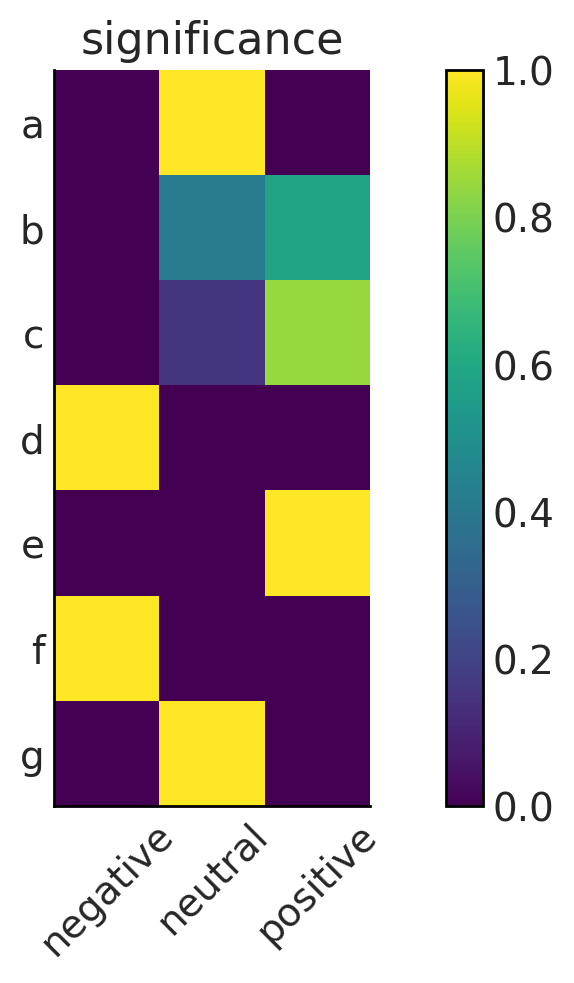

In [59]:
decisions = array_decisions(trace.posterior["uplift_p_relative"], 0.02).mean(["draw", "chain"])
plt.imshow(decisions.T, vmin=0, vmax=1)
plt.title("significance")
plt.yticks(*zip(*enumerate(decisions.coords["exp"].values)))
plt.xticks(*zip(*enumerate(decisions.coords["direction"].values)), rotation=45)
plt.colorbar();

### Conclusions
What we can say about the posterior plot is
* There are few experiments with uncertain posteriors: B, F, E
* While we are uncertain in the experiment E, it is certainly the best among others
* Experiment B is not as certain as C in the outcome. That is the data imbalance consequence
* Experiment E had little amount of supporting data but we could draw conclusions very fast

If we don't not look at the red dots with oracle results, the conclusions would stay unchanged. The posterior quite nice describes our updated knowledge about the uplifts after seeing data.

## Bayesian Decision Making, The Loss Function

It is always the case you need to make a decision about which experiment to choose. There is a fixed cost of implementing the decision and expected money income. Not all experiments are created equal, some may require more investments to implement and so on. All this information helps to make an informed decision. The loss function requires to reflect the main pain points:

1. Fixed cost of implementing the decision - may be different for experiments
3. Money outcome based on the uplift and the user-base

In [60]:
def monetization_estimate(
    *, 
    baseline_p, uplift, 
    implementation_cost, 
    per_user_income, 
    num_users
):
    return (
        per_user_income  # how much profit does one user generate.
        * num_users * uplift # Here we calculate how much additional users we genetate after implementing the decision.
        - implementation_cost # How much does it cost to implement
    )

Every parameter might be a distribution if needed. The loss function has nothing to do with fixed values.

### Shared Implementation Costs

In this example we assume that all the experiments are created equal. We only decide if we make more benefit

In [61]:
same_cost_outcomes = monetization_estimate(
    baseline_p=baseline_prob,
    uplift=trace.posterior["uplift_p"],
    implementation_cost=50000,
    per_user_income=12,
    num_users=1_000_000
)

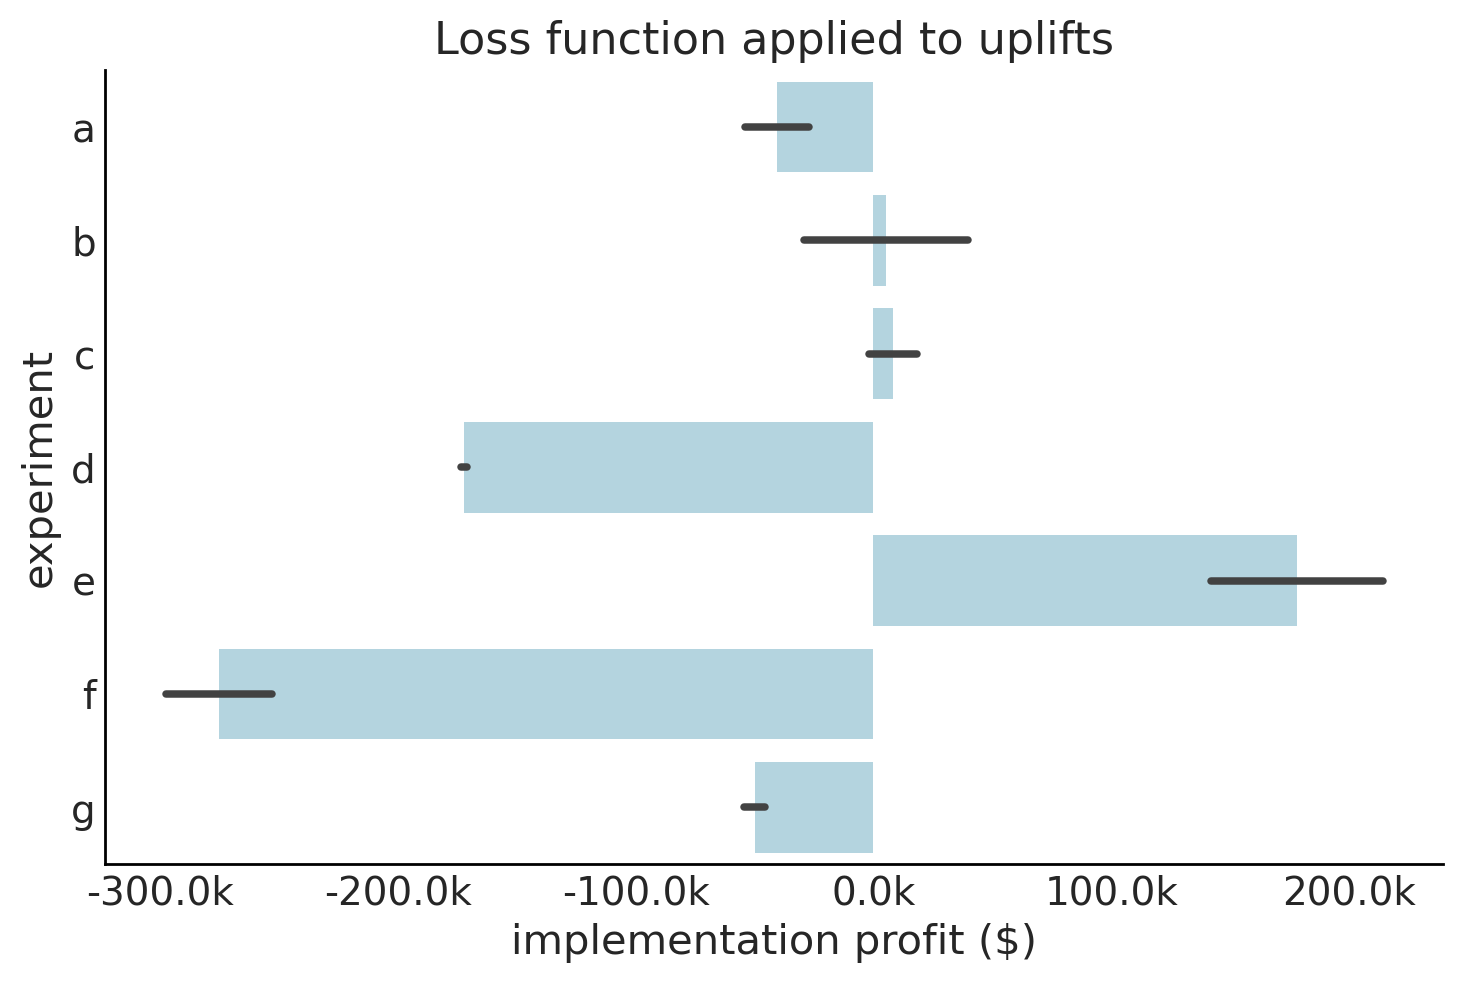

In [62]:
from matplotlib.ticker import FuncFormatter
ax = sns.barplot(
    y="exp",
    x="uplift_p",
    data=same_cost_outcomes.to_dataframe().reset_index(),
    errorbar="sd",
    color='lightblue',
)
ax.xaxis.set_major_formatter(FuncFormatter(lambda s, a: f"{s/1000}k"))
plt.xlabel("implementation profit ($)")
plt.ylabel("experiment")
plt.title("Loss function applied to uplifts");

* Experiments B and C share marginal improvement. However, the error bar for experiment B is larger. 
* Experiment E is again a clear winner no matter the error bars. 

### Variable Implementation Cost

This is a natural assumption not all experiments can be implemented in production that easy. The experiment E in the example might be a nasty thing in production nobody wants to implement due to a lot of problems. If they are justifiable is a good question.

In [64]:
variable_implementation_costs = xa.DataArray(
    [  # motivations to set the numbers
        10_000,  # not a big chunk of work, 2 months of work
        5_000,   # an easy improvement
        0,       # changing a hyperparameter in production
        75_000,  # a massive change in a production system to choose this
        200_000, # a vary nasty problem, hard to implement, easy to check
        -10_000, # this saves compute costs on AWS a lot
        2_000    # a junior can implement this in a week
    ],
   coords=dict(exp=["a", "b", "c", "d", "e", "f", "g"])
)

In [65]:
variable_implementation_costs

<xarray.DataArray (exp: 7)>
array([ 10000,   5000,      0,  75000, 200000, -10000,   2000])
Coordinates:
  * exp      (exp) <U1 'a' 'b' 'c' 'd' 'e' 'f' 'g'

In [68]:
variable_implementation_costs_outcomes = monetization_estimate(
    baseline_p=baseline_prob,
    uplift=trace.posterior["uplift_p"],
    implementation_cost=variable_implementation_costs,  # dollars
    per_user_income=12,
    num_users=1000000
)

In [69]:
#variable_implementation_costs_outcomes

In [73]:
variable_implementation_costs_outcomes.to_dataframe(name="uplift_p").reset_index()

,chain,draw,exp,uplift_p
0,0,0,a,5595.759820
1,0,0,b,31914.302900
2,0,0,c,52999.373964
3,0,0,d,-196252.874257
4,0,0,e,30713.442361
...,...,...,...,...
27995,3,999,c,62985.626473
27996,3,999,d,-198148.681224
27997,3,999,e,-27224.376956
27998,3,999,f,-199869.938627


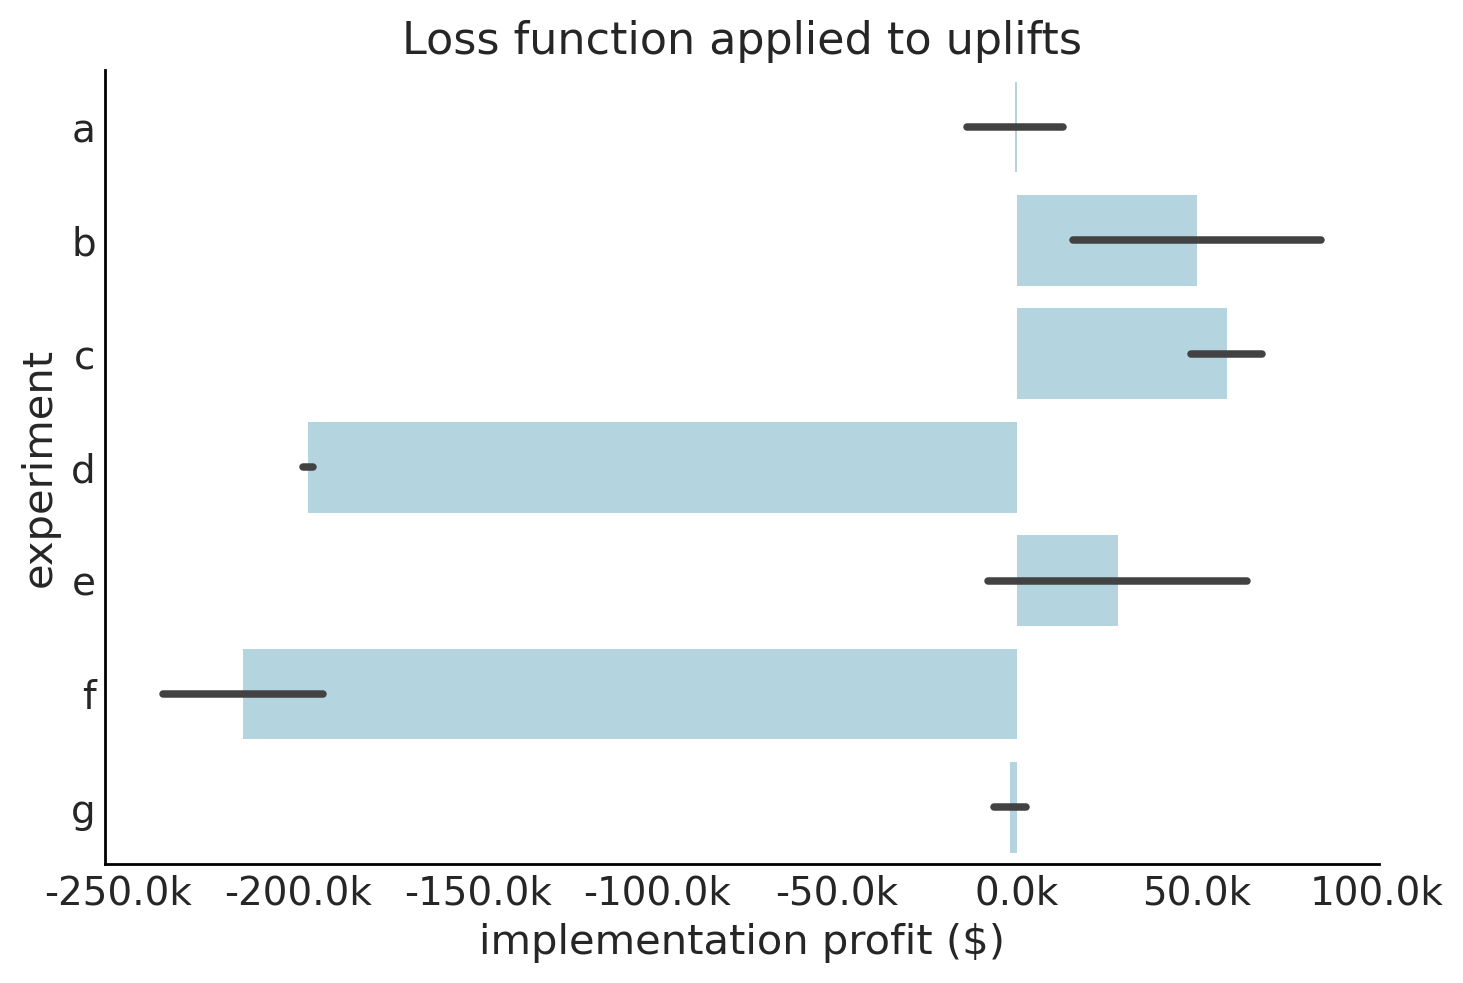

In [74]:
from matplotlib.ticker import FuncFormatter
ax = sns.barplot(
    y="exp",
    x="uplift_p",
    data=variable_implementation_costs_outcomes.to_dataframe(name="uplift_p").reset_index(),
    errorbar="sd",
    color='lightblue'
)
ax.xaxis.set_major_formatter(FuncFormatter(lambda s, a: f"{s/1000}k"))
plt.xlabel("implementation profit ($)")
plt.ylabel("experiment")
plt.title("Loss function applied to uplifts");

If we introduce the implementation costs as above. There is no clear winner any more. Experiments B, C, E look just the same. There is more certainty in the C experiment and it also looks appealing with the $5000 implementation cost.

### Bonus, User Income Uncertainty

Users are another degree of uncertainty in the decision making process. We can simulate different scenarios to decide what to choose.

In [75]:
users_scenario = xa.DataArray(
    [  # motivations to set the numbers
        12,   # we are lucky scenario
        10,   # base scenario
        8,    # pessimist scenatio
        5,    # historical minimum scenario
    ],
   coords=dict(scenario=["optimist", "realist", "pessimist", "minimum"])
)

In [76]:
users_scenario_outcomes = monetization_estimate(
    baseline_p=baseline_prob,
    uplift=trace.posterior["uplift_p"],
    implementation_cost=variable_implementation_costs,  # dollars
    per_user_income=users_scenario,
    num_users=1000000
)

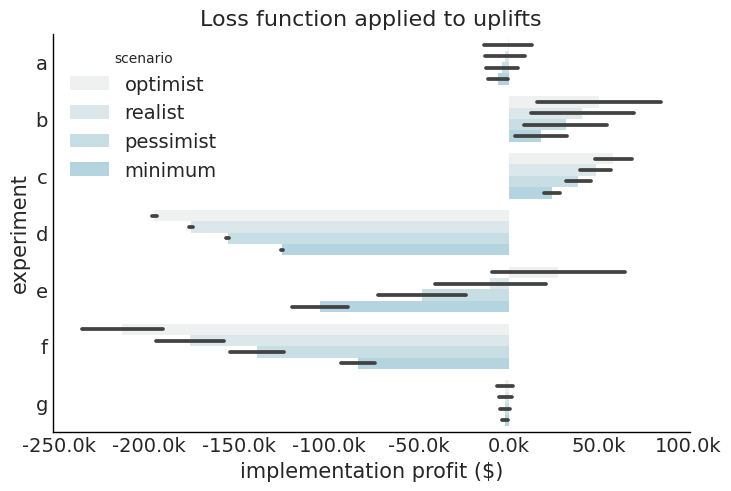

In [178]:
ax = sns.barplot(
    y="exp",
    x="uplift_p",
    hue="scenario",
    data=users_scenario_outcomes.to_dataframe(name="uplift_p").reset_index(),
    errorbar="sd",
    color='lightblue'
)
ax.xaxis.set_major_formatter(FuncFormatter(lambda s, a: f"{s/1000}k"))
plt.xlabel("implementation profit ($)")
plt.ylabel("experiment")
plt.title("Loss function applied to uplifts");

Adding scenarios to the analysis helped to evaluate risks in the implementation. The high risk project E holds only in positive scenarios and fails dramatically if bad days come. Depending on risk taking experiments B and C are good options.

## Winner under the loss function
Having calculated the implementation profit we can calculate the probability of a variant to be the best among others.

$$
P(\text{profit}_i > \max(\text{profit}_{-i}))
$$

In [182]:
list(trace.posterior.coords["exp"].values)

['a', 'b', 'c', 'd', 'e', 'f', 'g']

In [79]:
trace.posterior["uplift_p"].sel(exp="a")

<xarray.DataArray 'uplift_p' (chain: 4, draw: 1000)>
array([[ 1.29964665e-03,  4.08191287e-05,  1.77323875e-03, ...,
        -1.33737575e-03,  1.27656517e-03,  1.73646592e-04],
       [ 1.86287586e-03,  5.73278322e-04,  9.68417342e-04, ...,
         9.75686071e-05,  9.75686071e-05,  1.22164290e-03],
       [ 1.74601706e-03, -2.24404569e-04,  8.82477667e-04, ...,
        -1.40599389e-04, -9.03456758e-04,  9.18058835e-04],
       [ 1.14233404e-03, -2.14370063e-04, -7.97874996e-04, ...,
        -1.81898082e-05,  1.57526888e-03, -3.11050813e-06]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    exp      <U1 'a'

In [80]:
trace.posterior["uplift_p"].drop_sel(exp="a")

<xarray.DataArray 'uplift_p' (chain: 4, draw: 1000, exp: 6)>
array([[[ 3.07619191e-03,  4.41661450e-03, -1.01044062e-02,
          1.92261202e-02, -2.16872075e-02, -3.07624780e-05],
        [ 2.56223004e-03,  3.95627638e-03, -1.02052350e-02,
          1.55587172e-02, -1.67236028e-02,  1.45803846e-04],
        [ 6.39582475e-03,  5.48604571e-03, -1.01306085e-02,
          2.21165717e-02, -2.12761151e-02,  4.08098913e-05],
        ...,
        [ 3.52746278e-03,  5.25442533e-03, -1.02108804e-02,
          1.51874240e-02, -2.24389608e-02,  8.24874343e-05],
        [ 5.31091823e-03,  4.04648881e-03, -1.01058043e-02,
          1.82577147e-02, -1.74751220e-02, -5.05429717e-04],
        [ 4.25068050e-03,  5.66980284e-03, -1.02149890e-02,
          2.04430101e-02, -1.96968520e-02,  5.45754016e-04]],

       [[ 6.01397389e-03,  5.84770405e-03, -9.89365410e-03,
          2.19727436e-02, -1.68056381e-02, -4.49953713e-04],
        [ 2.44578579e-03,  4.98769647e-03, -1.04675545e-02,
          2.01486541e-02, -1.93383363e-02,  1.84468964e-04],
        [ 2.85900668e-03,  3.02053673e-03, -1.02382069e-02,
          1.96033530e-02, -1.88353620e-02, -6.27973101e-05],
...
        [ 4.59744893e-03,  4.37479861e-03, -1.04549640e-02,
          2.18867666e-02, -2.00201914e-02,  9.89562162e-05],
        [ 4.07842899e-03,  6.01543353e-03, -1.02501946e-02,
          1.53756943e-02, -1.90621132e-02,  1.91460922e-04],
        [ 4.59610773e-03,  3.80181806e-03, -1.00710831e-02,
          2.22312986e-02, -1.81178597e-02, -1.26468131e-04]],

       [[ 1.25773041e-03,  4.78504470e-03, -1.01824610e-02,
          1.58611810e-02, -1.71398957e-02, -5.30911375e-04],
        [ 5.59000529e-03,  4.10168966e-03, -1.01378827e-02,
          1.86578940e-02, -1.94946438e-02,  5.47586470e-04],
        [ 5.67247890e-03,  4.58572313e-03, -1.02762804e-02,
          2.13142492e-02, -2.03157251e-02,  8.39043358e-04],
        ...,
        [ 5.41657976e-03,  5.18245340e-03, -1.01369426e-02,
          2.14257686e-02, -1.75772774e-02, -3.44046433e-04],
        [ 3.79186320e-03,  4.49202788e-03, -1.01904335e-02,
          1.62953563e-02, -1.93693534e-02,  5.05455034e-04],
        [ 3.57813053e-03,  5.24880221e-03, -1.02623901e-02,
          1.43979686e-02, -1.74891616e-02, -2.34930658e-05]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * exp      (exp) <U1 'b' 'c' 'd' 'e' 'f' 'g'

In [81]:
def exp_beats_all(outcomes, exp):
    return (outcomes.sel(exp=exp) > outcomes.drop_sel(exp=exp).max("exp")).mean(["chain", "draw"])

def all_beats_all(outcomes):
    return xa.concat(
        [exp_beats_all(outcomes=outcomes, exp=e) 
         for e in outcomes.coords["exp"].values], dim=outcomes.coords["exp"]
    )

In [82]:
users_scenario_outcomes_beats_all = all_beats_all(users_scenario_outcomes)

In [84]:
users_scenario_outcomes_beats_all.round(2)

<xarray.DataArray (exp: 7, scenario: 4)>
array([[0.  , 0.  , 0.  , 0.  ],
       [0.37, 0.39, 0.38, 0.33],
       [0.48, 0.58, 0.62, 0.67],
       [0.  , 0.  , 0.  , 0.  ],
       [0.15, 0.03, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ]])
Coordinates:
  * scenario  (scenario) <U9 'optimist' 'realist' 'pessimist' 'minimum'
  * exp       (exp) <U1 'a' 'b' 'c' 'd' 'e' 'f' 'g'

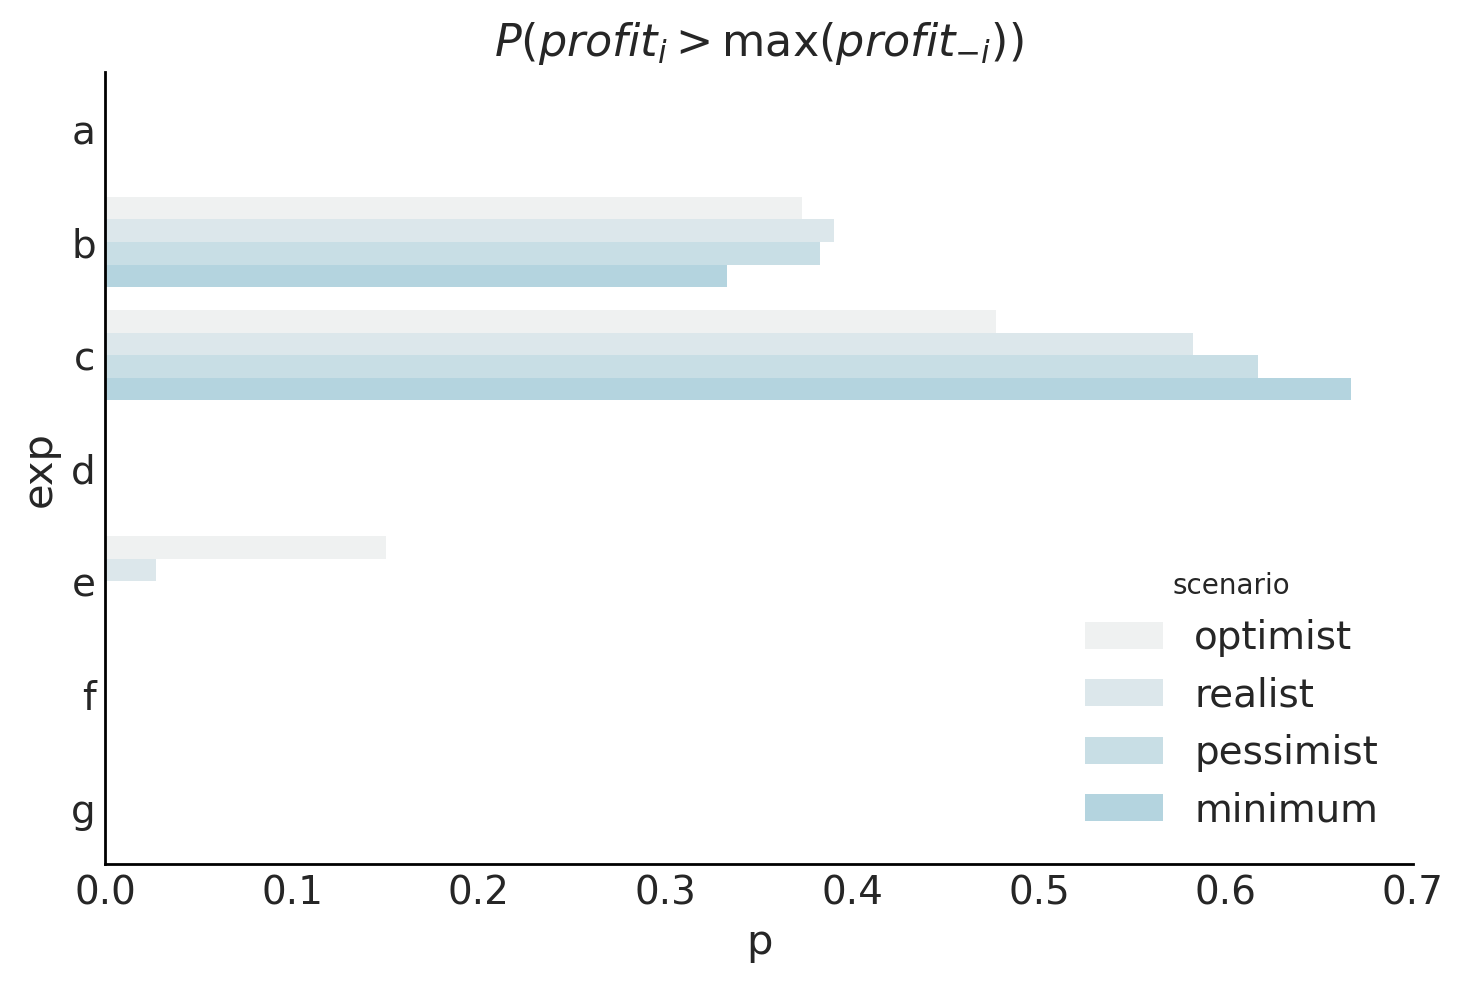

In [85]:
sns.barplot(
    x="p", y="exp", hue="scenario", color='lightblue',
    data=users_scenario_outcomes_beats_all.to_dataframe(name="p").reset_index())
plt.title(r"$P({profit}_i > \max({profit}_{-i}))$");

## Final remarks

There are a lot more in depth analysis that could be done with the Bayesian framework. We've touched only a couple of things so far. 

* Imbalanced datasets
* Loss functions
* Scenario testing

Bayesian decision making allows to make more informed decisions that rely on a principled methodology you can interpret, understand and explain.

In [139]:

with pm.Model() as model:
    N = pm.ConstantData("N", 100000)
    p1 = pm.Beta("p1", mu=0.1, sigma=0.1*0.1)
    p2 = pm.Beta("p2", mu=0.3, sigma=0.3*0.1)
    N1 = pm.Binomial("N1", n=N, p=p1)
    N2 = pm.Binomial("N2", n=N1, p=p2)

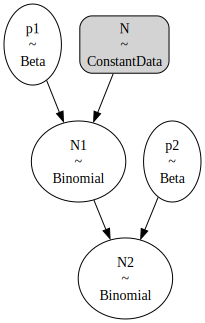

In [140]:
pm.model_to_graphviz(model)

In [119]:
with pm.do(model, {"p1": 0.11, "p2": 0.27}):
    prior = pm.sample_prior_predictive(1)

Sampling: [N1, N2]


In [120]:
prior.prior["N1"].sel(chain=0, draw=0)

<xarray.DataArray 'N1' ()>
array(11135)
Coordinates:
    chain    int64 0
    draw     int64 0

In [121]:
with pm.observe(model, {
    "N1": prior.prior["N1"].sel(chain=0, draw=0),
    "N2": prior.prior["N2"].sel(chain=0, draw=0)
}) as observed_model:
    ...

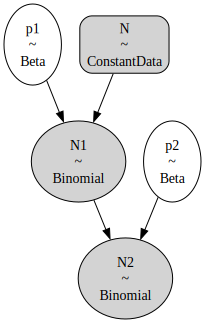

In [122]:
pm.model_to_graphviz(observed_model)

In [123]:
with observed_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p1, p2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'p1'}>, <Axes: title={'center': 'p1'}>],
       [<Axes: title={'center': 'p2'}>, <Axes: title={'center': 'p2'}>]],
      dtype=object)

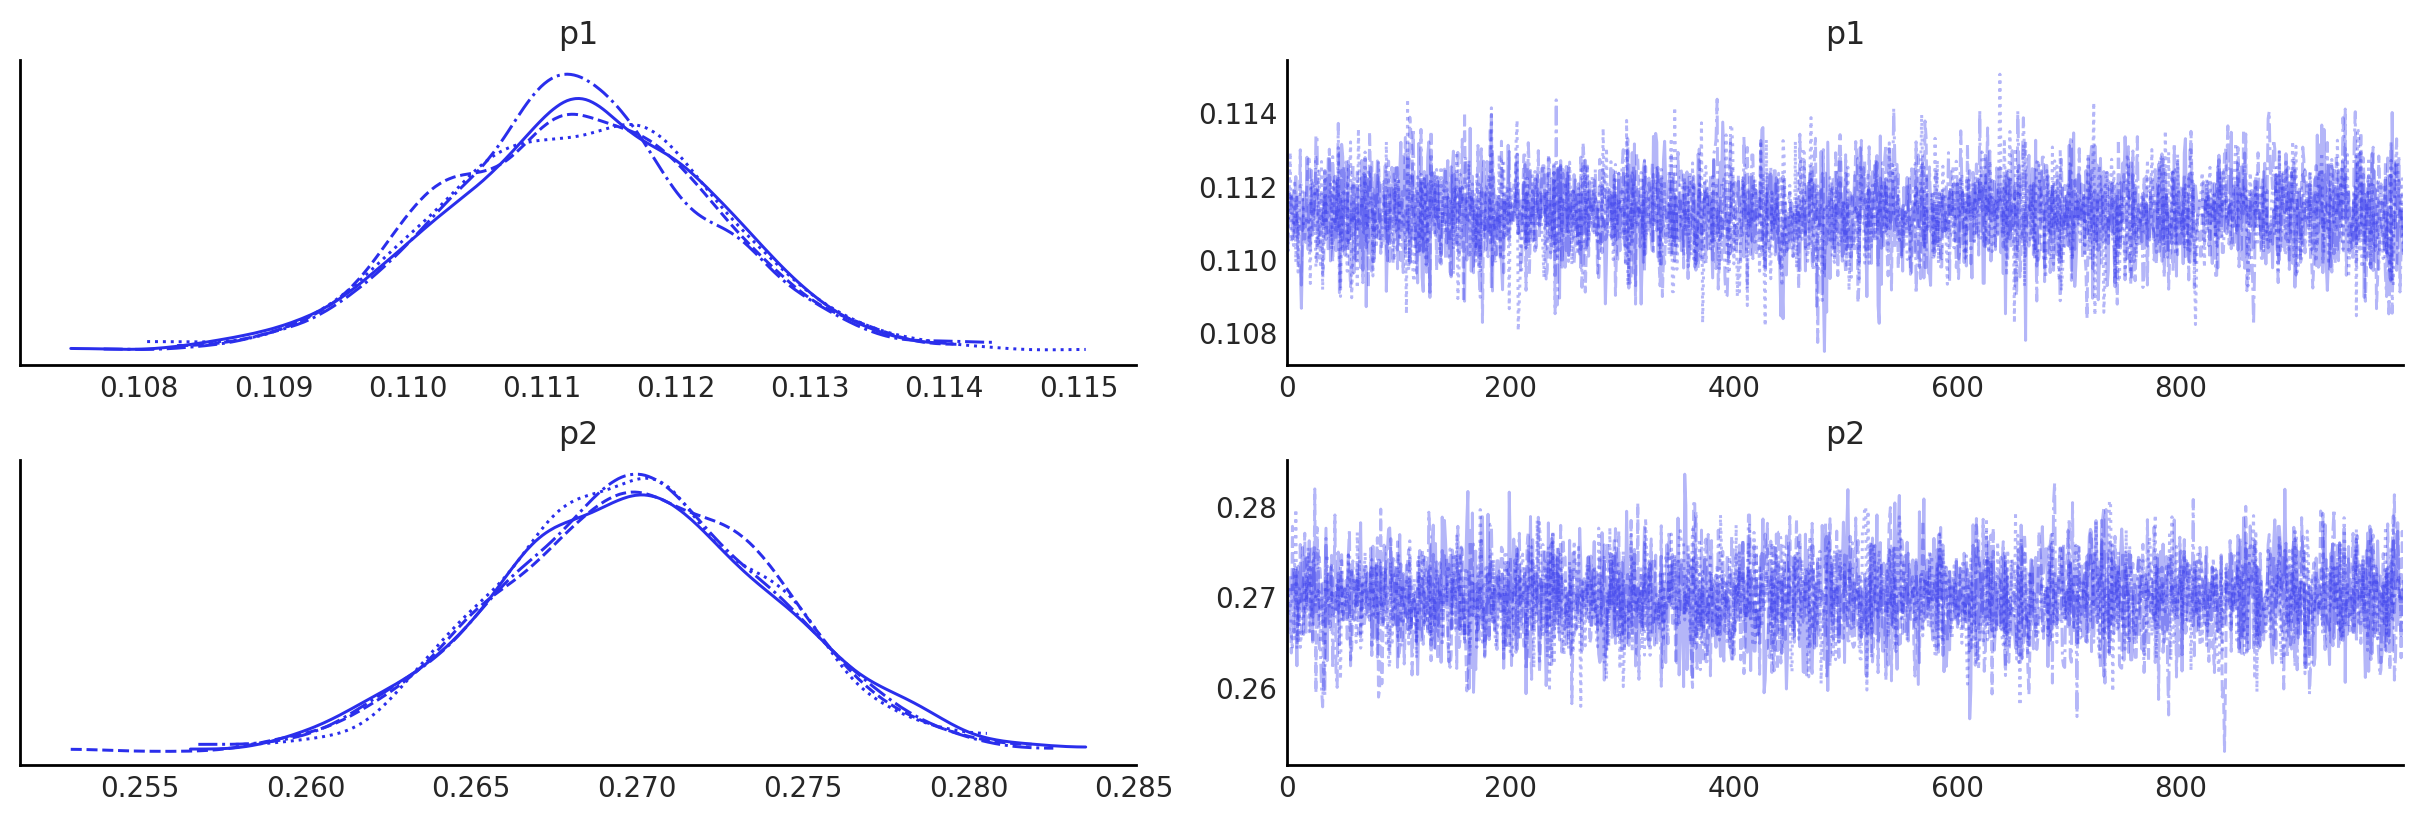

In [124]:
az.plot_trace(trace)

In [125]:
with observed_model:
    trace1 = pm.sample_posterior_predictive(trace)

Sampling: [N1, N2]


In [126]:
trace1.posterior_predictive["N1"]

<xarray.DataArray 'N1' (chain: 4, draw: 1000)>
array([[11257, 10997, 11287, ..., 11264, 11095, 10798],
       [10965, 11143, 11267, ..., 11175, 11408, 11100],
       [11306, 11029, 11118, ..., 11070, 11095, 10984],
       [10983, 11312, 11099, ..., 10916, 11222, 11190]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [127]:
trace1.posterior_predictive["N2"]

<xarray.DataArray 'N2' (chain: 4, draw: 1000)>
array([[3039, 2996, 3086, ..., 3033, 3042, 2971],
       [2889, 3078, 3020, ..., 2989, 3134, 3018],
       [3074, 3018, 2964, ..., 2960, 3014, 3114],
       [2936, 3067, 3000, ..., 2867, 3075, 2999]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [135]:
with pm.do(observed_model, {"N": 1000000000, "p1": 0.99}):
    trace1 = pm.sample_posterior_predictive(trace)

Sampling: [N1, N2]


In [136]:
trace1.posterior_predictive["N1"]

<xarray.DataArray 'N1' (chain: 4, draw: 1000)>
array([[990000216, 990003537, 989996724, ..., 990000081, 989996719,
        989999162],
       [989997491, 990003459, 989998709, ..., 989998241, 989995275,
        989997683],
       [989999855, 990003195, 989995719, ..., 989996604, 989997282,
        989997730],
       [989995618, 990001234, 989999577, ..., 989999896, 990001089,
        989995338]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [133]:
trace1.posterior_predictive["N2"]

<xarray.DataArray 'N2' (chain: 4, draw: 1000)>
array([[30179240, 30234998, 30241342, ..., 30011603, 30011630, 29885557],
       [29776150, 29976120, 29993506, ..., 29993644, 30359487, 29928641],
       [30159261, 29592090, 29766822, ..., 29118488, 30740923, 30249262],
       [29904895, 30016934, 29916626, ..., 29285327, 30171420, 30164292]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999